# Truncated regression

**Author:** [Ben Vincent](https://github.com/drbenvincent)

The notebook provides an example of how to conduct linear regression when you have a truncated outcome variable. Truncation is a type of missing data problem where you are simply unaware of any data that falls outside of a certain set of bounds.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.10.0


In [2]:
%config InlineBackend.figure_format = 'retina'

For this example of `(x, y)` scatter data, we can describe the truncation process as simply filtering out any data for which our outcome variable `y` falls outside of a set of bounds.

In [3]:
def truncate_y(x, y, bounds):
    keep = (y >= bounds[0]) & (y <= bounds[1])
    return (x[keep], y[keep])

Generate some true (latent) data before any truncation takes place. In the real world, you would not have access to this `(x, y)` data.

In [4]:
m, c, σ, N = 1, 0, 2, 200
x = np.random.uniform(-10, 10, N)
y = np.random.normal(m * x + c, σ)

Rather, in a real world context, you would have access to truncated data, where our outcome variable `y` falls within the bounds.

In [5]:
bounds = [-5, 5]
xt, yt = truncate_y(x, y, bounds)

We can visualise this latent data (in grey) and the remaining truncated data (black) as below.

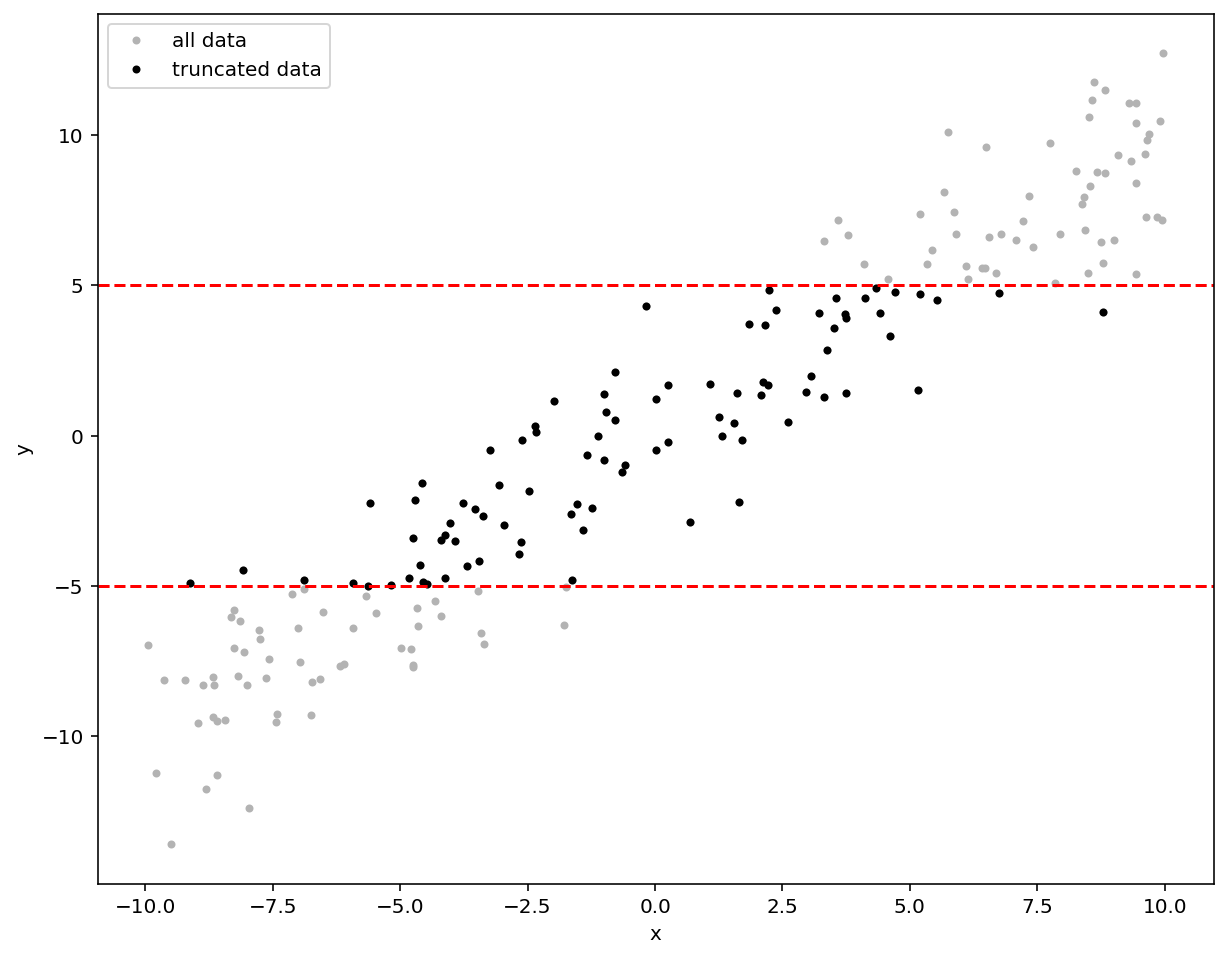

In [6]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(x, y, '.', c=[0.7, 0.7, 0.7], label="all data")
ax.plot(xt, yt, '.', c=[0, 0, 0], label="truncated data")
ax.axhline(bounds[0], c='r', ls='--')
ax.axhline(bounds[1], c='r', ls='--')
ax.set(xlabel="x", ylabel="y")
ax.legend();

## Linear regression of truncated data underestimates the slope

Before we get into truncated regression, it is useful to understand why it is needed. If you haven't guessed already from the plot above, then a regression on the truncated data is likely to underestimate the true regression slope. Let's see that in action.

In [7]:
def linear_regression(x, y):

    with pm.Model() as model:
        m = pm.Normal("m", mu=0, sd=1)
        c = pm.Normal("c", mu=0, sd=1)
        σ = pm.HalfNormal("σ", sd=1)
        y_likelihood = pm.Normal("y_likelihood", mu=m*x+c, sd=σ, observed=y)

    with model:
        trace = pm.sample()

    return model, trace

In [8]:
# run the model on the truncated data (xt, yt)
linear_model, linear_trace = linear_regression(xt, yt)

/Users/benjamv/opt/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, c, m]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


/Users/benjamv/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


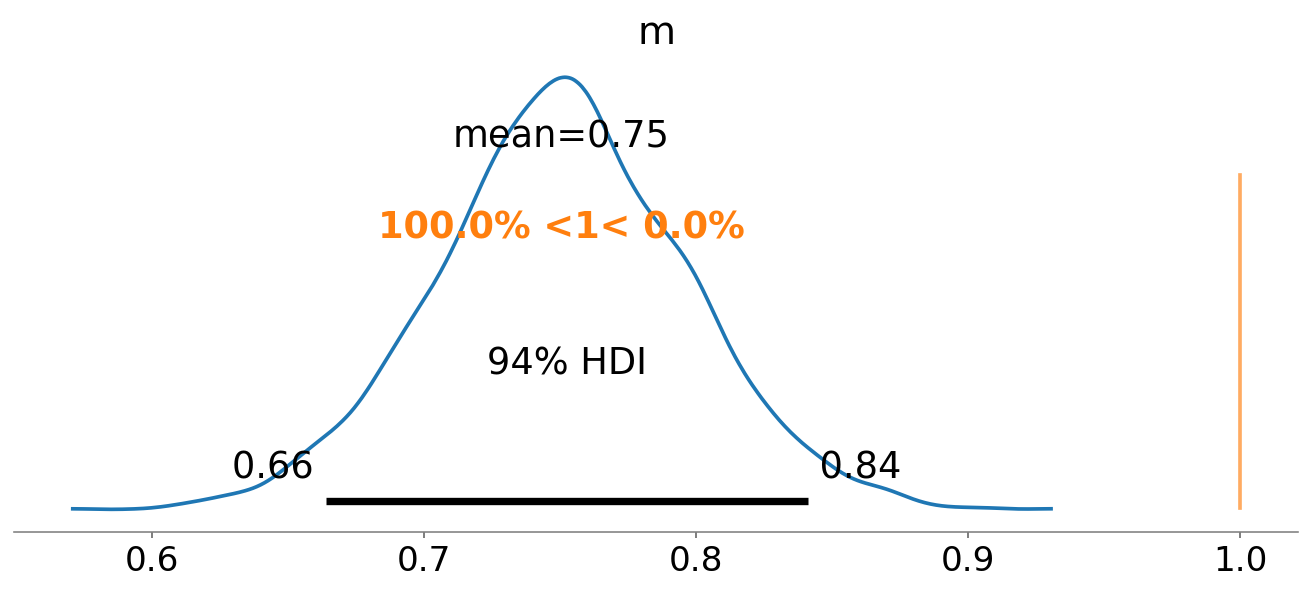

In [9]:
az.plot_posterior(linear_trace, var_names=['m'], ref_val=m, figsize=(9, 4));

As we can see, the posterior of the regression slope `m` is underestimated, by quite lot in this example.

Let's visualise how bad that fit is by plotting the data and posterior predictions.

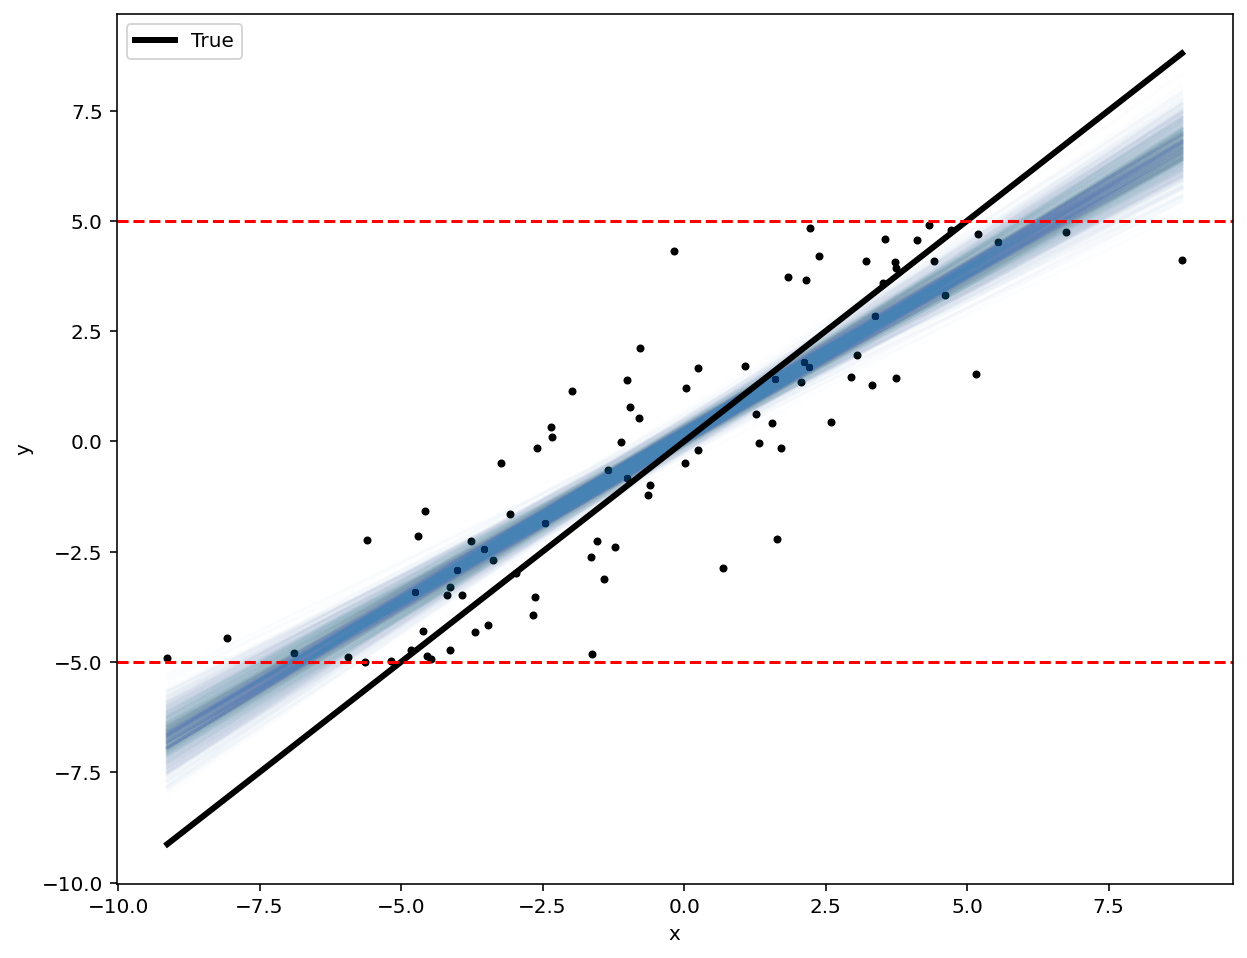

In [10]:
def pp_plot(x, y, trace):
    fig, ax = plt.subplots(figsize=(10, 8))
    # plot data
    ax.plot(x, y, 'k.')
    # plot posterior predicted... samples from posterior
    xi = np.array([np.min(x), np.max(x)])
    n_samples=1000
    for n in range(n_samples):
        y_ppc = xi * trace["m"][n] + trace["c"][n]
        ax.plot(xi, y_ppc, c="steelblue", alpha=0.01, rasterized=True)
    # plot true
    ax.plot(xi, m * xi + c, "k", lw=3, label="True")
    # plot bounds
    ax.axhline(bounds[0], c='r', ls='--')
    ax.axhline(bounds[1], c='r', ls='--')
    ax.legend()
    ax.set(xlabel="x", ylabel="y")
    
pp_plot(xt, yt, linear_trace)

We can see that the degree of estimation bias will depend upon a number of things, including the truncation boundaries and the measurement noise. In some situations with high measurement precision and/or little measurement noise, the estimation bias may not be very large. Otherwise, this could have a negative impact upon your research conclusions.

## Truncated regression avoids this underestimate

Truncated regression solves this problem. By using a truncated normal likelihood distribution we are explicity stating our knowledge about the generative process which gave rise to your dataset. We can impliment a [truncated regression model](https://en.wikipedia.org/wiki/Truncated_regression_model) as below.

In [11]:
def truncated_regression(x, y, bounds):

    with pm.Model() as model:
        m = pm.Normal("m", mu=0, sd=1)
        c = pm.Normal("c", mu=0, sd=1)
        σ = pm.HalfNormal("σ", sd=1)

        y_likelihood = pm.TruncatedNormal(
            "y_likelihood",
            mu=m * x + c,
            sd=σ,
            observed=y,
            lower=bounds[0],
            upper=bounds[1],
        )
    
    with model:
        trace = pm.sample()

    return model, trace

In [12]:
# run the model on the truncated data (xt, yt)
truncated_model, truncated_trace = truncated_regression(xt, yt, bounds)

WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tens

And we can check that the inferences are much better by examining the posterior distribution over our slope parameter `m`.

/Users/benjamv/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implement

<AxesSubplot:title={'center':'m'}>

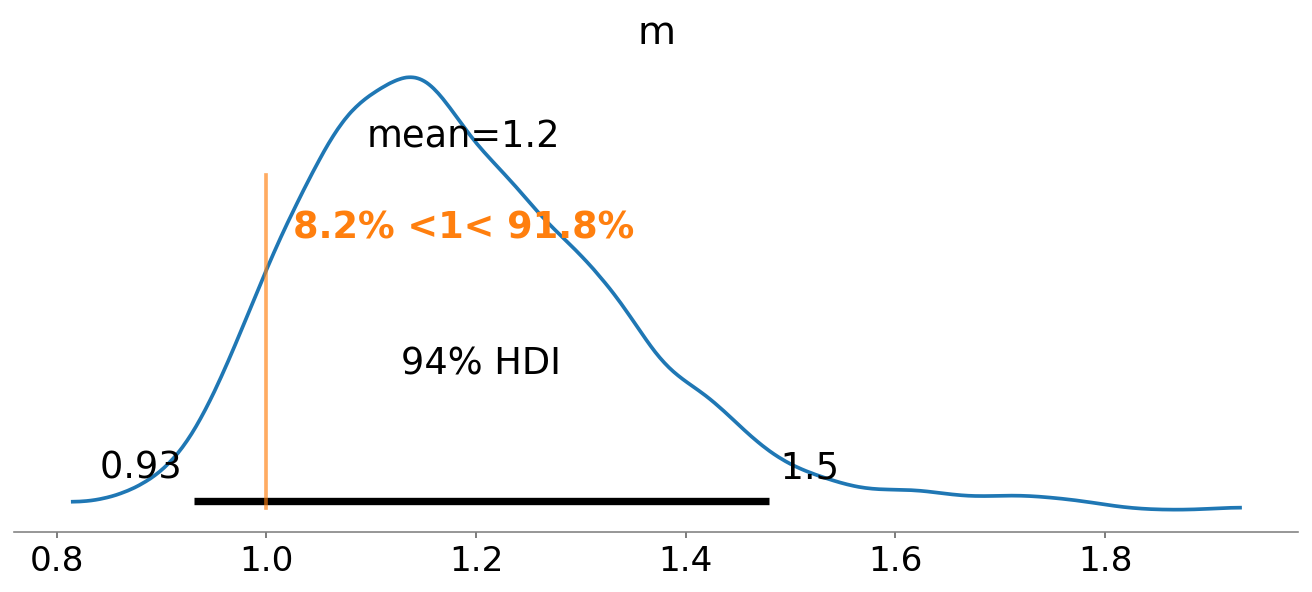

In [13]:
az.plot_posterior(truncated_trace, var_names=['m'], ref_val=m, figsize=(9, 4))

And also by doing our graphical posterior predictive checks. Looks good.

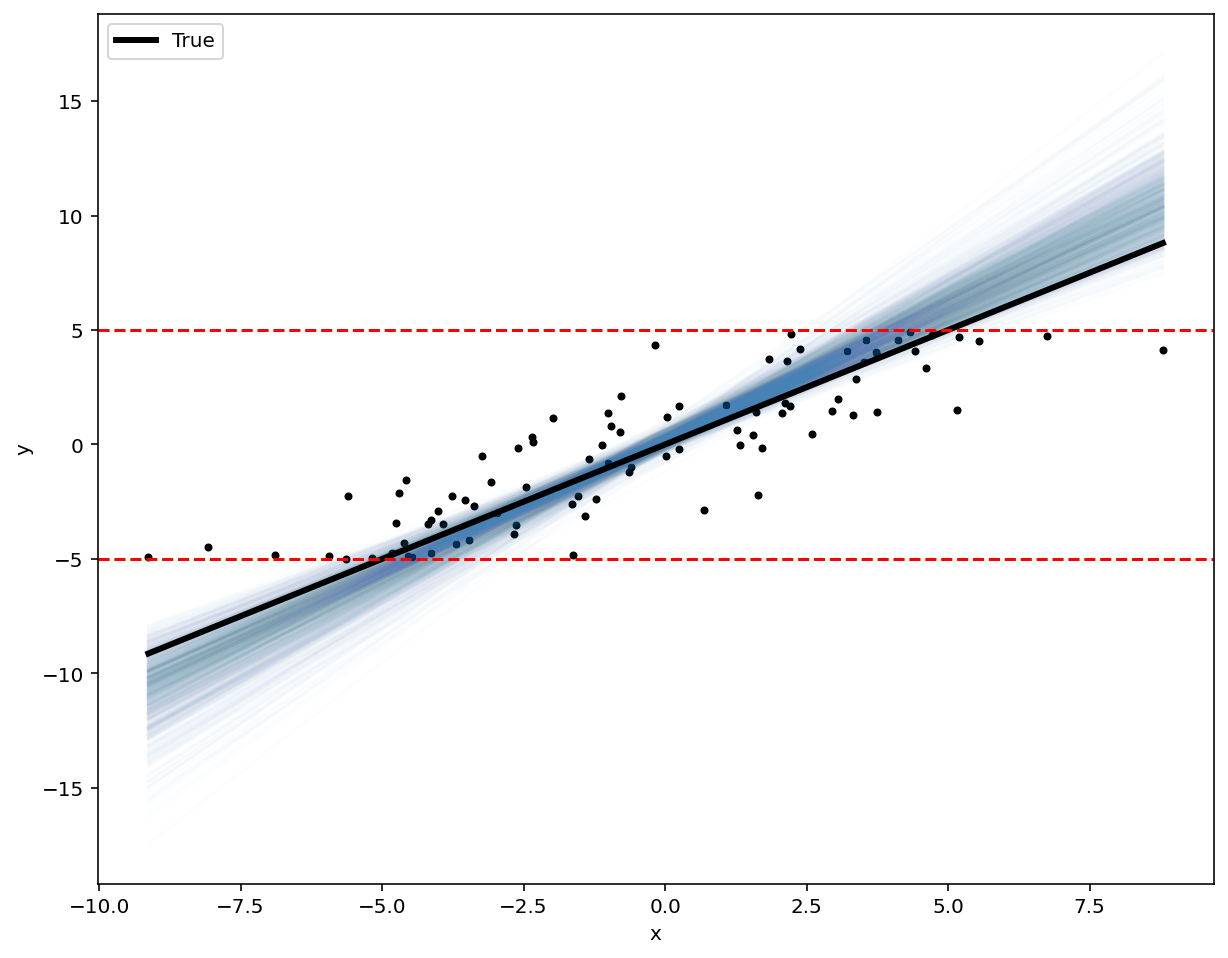

In [14]:
pp_plot(xt, yt, truncated_trace)

In [15]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Jan 24 2021

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

pymc3     : 3.10.0
matplotlib: 3.3.2
numpy     : 1.19.2
arviz     : 0.11.0

Watermark: 2.1.0

